In [1]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner
from astropy.stats import LombScargle


In [17]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/2M1314e4-LLRR.dat')
binned = binning(dt,sec=10)
binned = binned[binned['nsamp']>6000]

def binPlot(Type='minutes'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

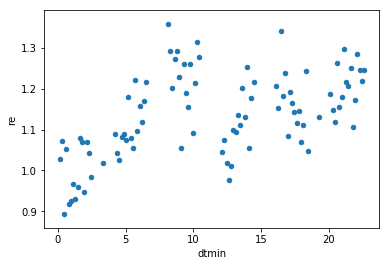

In [16]:
test = binned[binned['nsamp']>6000]
test.plot.scatter('dtmin','re')

In [22]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if 0 < m < 1 and 0.5 < b < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [19]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [20]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


0.007786491612621075 1.0465521611036595


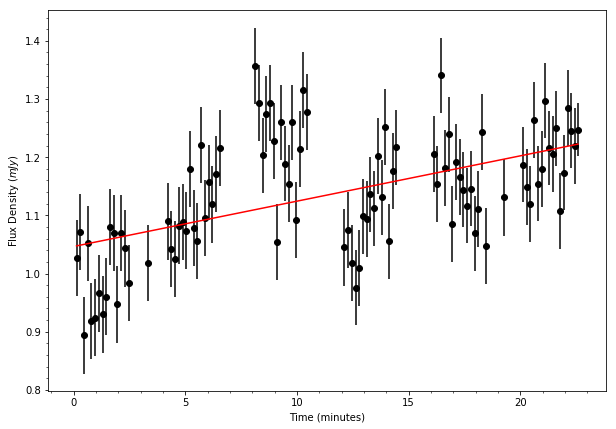

In [21]:
# Plotting results from maximized likelihood
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e4_linearModel.png')
plt.show()

In [23]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)
linearSampler.reset()

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[0.00726828, 1.05126046],
        [0.00693179, 1.04929516],
        [0.00949606, 1.02098208],
        [0.00823963, 1.04320385],
        [0.00834517, 1.03864373],
        [0.00884641, 1.02938323],
        [0.0077695 , 1.05983034],
        [0.00693537, 1.05238744],
        [0.00716195, 1.06921578],
        [0.00973354, 1.020481  ],
        [0.00796116, 1.0361048 ],
        [0.00942455, 1.0284145 ],
        [0.00705249, 1.05972368],
        [0.00561143, 1.06858495],
        [0.00708745, 1.05738855],
        [0.00583136, 1.06919166],
        [0.00675855, 1.04043155],
        [0.00824779, 1.04675363],
        [0.0079905 , 1.04864443],
        [0.00935188, 1.03617147],
        [0.00903533, 1.04582877],
        [0.00906895, 1.02301088],
        [0.00650115, 1.04937478],
        [0.00659159, 1.06636798],
        [0.00794946, 1.04268397],
        [0.00665671, 1.06287793],
        [0.0072563 , 1.05766261],
        [0.00919399, 1.04267688],
        [0.00699029, 1.05201855],
        [0.008

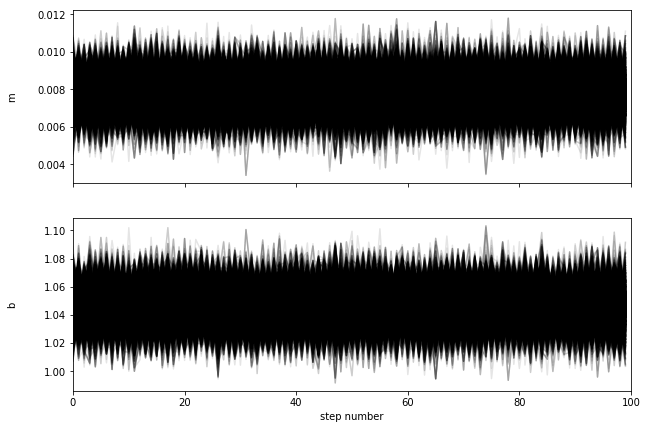

In [24]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e4_linearTrace.png')
plt.show()

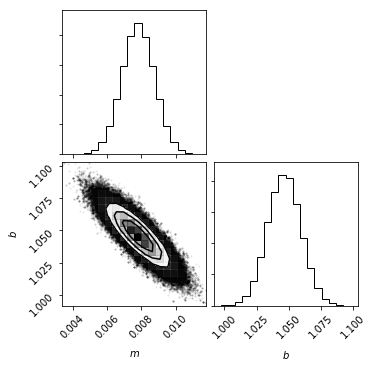

In [25]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/1314e4_linearCorner.png')
plt.show()

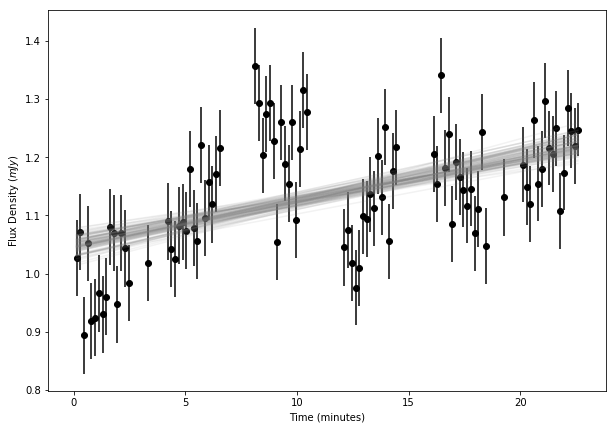

In [26]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e4_500mcmc_data.png')
plt.show()

In [27]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

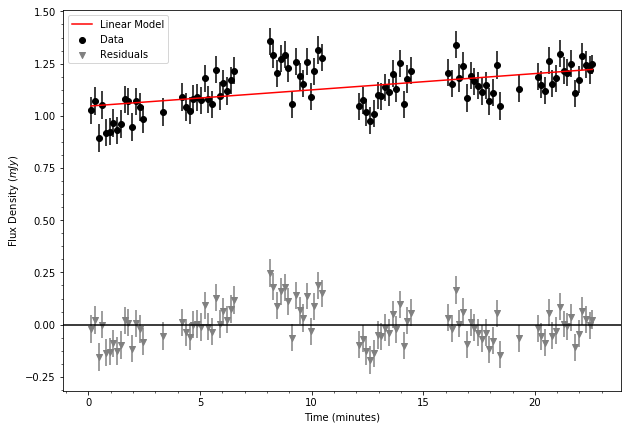

In [28]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(10,7))
plt.scatter(x,y,color='k',marker='o',label='Data')
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None',label='_nolegend_')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.scatter(x,linear_resid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e4_linearModel_fit.png')
plt.show()

In [29]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/(len(x)-2)

1.8458570338278855

In [32]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if -0.1 < l < 0.5 and -5 < k < 10 and 2 < x0 < 10 and 0.01 < y0 < 1.5:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [31]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

0.1818821669043138 1.5536313393159065 4.8802075036221595 0.9955360547417079


In [33]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

(array([[0.17730428, 2.97960721, 4.19798292, 0.98604288],
        [0.15466226, 6.28276401, 4.51603197, 1.01786024],
        [0.15645007, 4.22504052, 5.50950264, 1.01899987],
        [0.18375155, 1.97936423, 5.05823746, 1.00339697],
        [0.14648795, 1.76595024, 4.94961199, 1.00992288],
        [0.21584086, 0.98193   , 4.4717205 , 0.95468772],
        [0.17331146, 3.50350119, 5.16401761, 1.00014023],
        [0.13957451, 5.52703541, 4.85321299, 1.02856098],
        [0.13836159, 7.7850068 , 5.06706652, 1.03394326],
        [0.16889695, 4.83683176, 4.84579752, 1.00518492],
        [0.17151201, 1.29272453, 4.29174654, 0.99257796],
        [0.16798042, 0.77662408, 3.99476583, 0.99950527],
        [0.1965521 , 1.8118642 , 4.99198047, 0.98924207],
        [0.20989985, 1.4770473 , 4.32166853, 0.97828983],
        [0.16984559, 1.54129037, 5.43470683, 1.00454886],
        [0.16941763, 2.8365766 , 4.94322836, 0.990071  ],
        [0.16466827, 1.51347285, 5.31438292, 1.00805791],
        [0.140

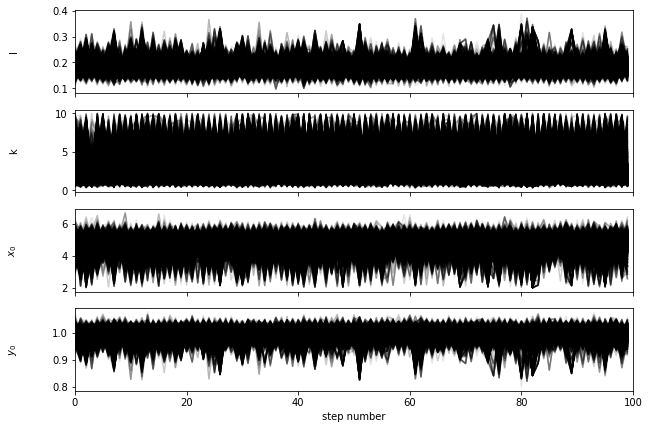

In [34]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,7),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e4_Trace.png')
plt.show()

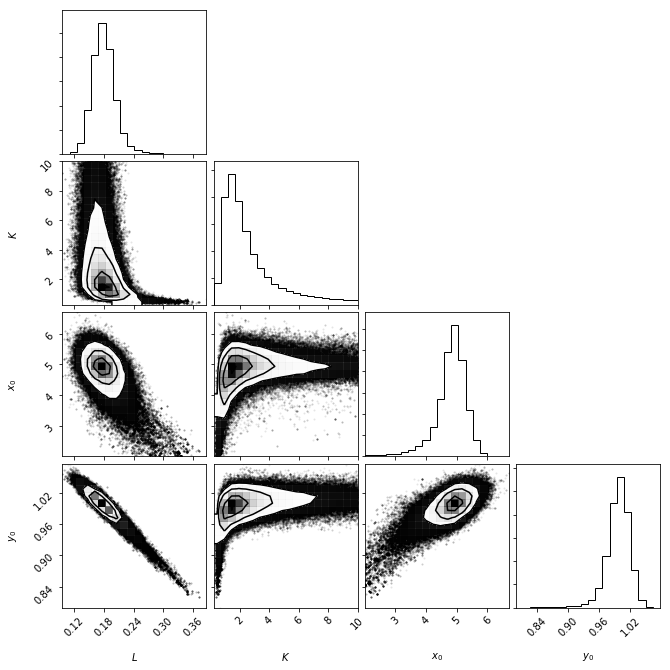

In [35]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/1314e4_logCorner.png')
plt.show()

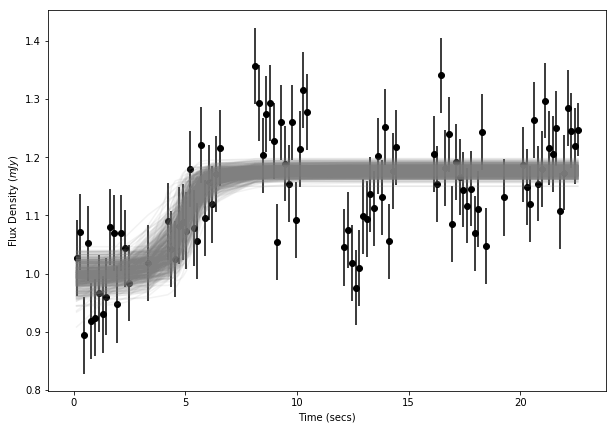

In [36]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e4_500mcmc_log.png')
plt.show()

In [37]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

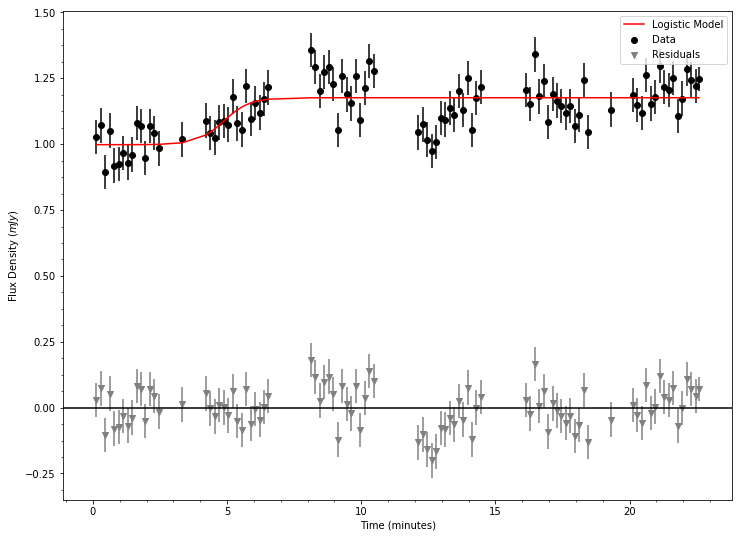

In [39]:
# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel(logParameters,x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(12,9))
binPlot(Type='minutes')
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/1314e4_logModel.png')
plt.show()

In [40]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/(len(x)-4)

1.456748944803133

In [45]:
rr = pd.read_table('1314/2M1314e4-RR.dat')
ll = pd.read_table('1314/2M1314e4-LL.dat')

rr = rr[rr['nsamp']>3000]
ll = ll[ll['nsamp']>3000]

rr = binning(rr,10)
ll = binning(ll,10)
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

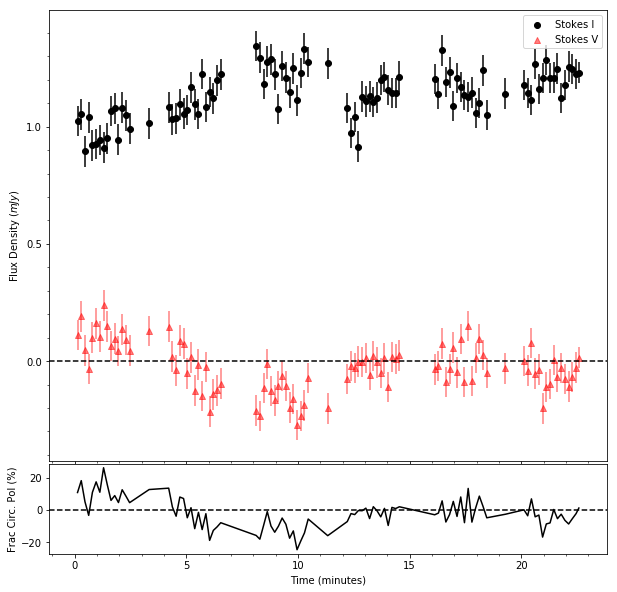

In [46]:
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':.01,'height_ratios':[5,1]})
ax[0].scatter(time,stI,color='black',marker='o',label='Stokes I')
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(time,stV,color='red',marker='^',label='Stokes V',alpha=0.5)
ax[0].errorbar(time,stV,yerr=stErr,color='red',linestyle='None',label='_nolegend_',alpha=0.5)
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='dashed')
ax[1].set_ylabel('Frac Circ. Pol (%)')

plt.xlabel('Time (minutes)')
plt.show()

In [4]:
high = pd.read_table('1314/2M1314e4-7GHz.dat')
low = pd.read_table('1314/2M1314e4-5GHz.dat')

high = high[high['nsamp']>3000]
low = low[low['nsamp']>3000]

high = binning(high,10)
low = binning(low,10)


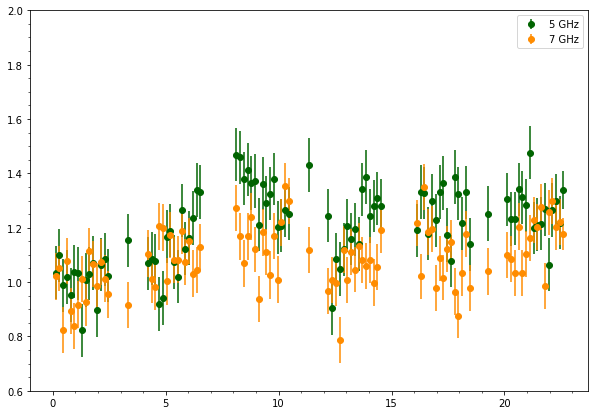

In [5]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',linestyle='None',color='darkgreen',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='o',linestyle='None',color='darkorange',label='7 GHz')
plt.minorticks_on()
plt.legend(loc='best')
plt.ylim(0.6,2.0)
plt.show()